<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/KMG/new_start_graph1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate -U
!pip install transformers[torch] -U
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
import pandas as pd

In [5]:
#df = pd.read_csv('/content/drive/MyDrive/Dataset/prototype5.csv')
df = pd.read_csv('/content/drive/MyDrive/Dataset/final/MSR+julite+Div_final_train(feature).csv')

In [6]:
import pandas as pd
import re
import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from pandas.core.common import random_state
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import logging
import sklearn.metrics as metric
from transformers import DataCollatorWithPadding
import torch,gc
from sklearn.metrics.pairwise import cosine_similarity
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from transformers import RobertaForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base", num_labels = 10)
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
batch_size = 16
epoch_num = 1000
MAX_LEN = 512
learning_rate = 2e-5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [8]:
import re

def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df['code'] = df['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [9]:
preprocess(df,"preprocess.csv")
dataset = load_dataset("csv",data_files="preprocess.csv")['train']
encoded_dataset = dataset.map(tokenized,remove_columns=['code'],batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15638 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
dataset['code'][3]

'void func(char *name, struct net_device *master){ isdn_net_dev *netdev; if (isdn_net_findif(name)) { printk(KERN_WARNING "isdn_net: interface %s already exists\\n", name); } if (name == NULL) if (!(netdev = kzalloc(sizeof(isdn_net_dev), GFP_KERNEL))) { printk(KERN_WARNING "isdn_net: Could not allocate net-device\\n"); } netdev->dev = alloc_netdev(sizeof(isdn_net_local), name, _isdn_setup); if (!netdev->dev) { printk(KERN_WARNING "isdn_net: Could not allocate network device\\n"); kfree(netdev); } netdev->local = netdev->dev->priv; netdev->dev->init = isdn_net_init; if (master) { struct net_device *p = (((isdn_net_local *) master->priv)->slave); struct net_device *q = master; netdev->local->master = master; while (p) { q = p; p = (((isdn_net_local *) p->priv)->slave); } ((isdn_net_local *) q->priv)->slave = netdev->dev; } else { netdev->dev->tx_timeout = isdn_net_tx_timeout; netdev->dev->watchdog_timeo = ISDN_NET_TX_TIMEOUT; if (register_netdev(netdev->dev) != 0) { printk(KERN_WARNING "

In [10]:
encoded_dataset = encoded_dataset.train_test_split(0.3,seed=100)

In [11]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['CWE ID', 'vul', 'lang', 'labels', 'chmod()', 'assert()', 'atoi()', 'atof()', 'calloc()', 'errno()', 'exit()', 'fclose()', 'fopen()', 'free()', 'gets()', 'read()', 'scanf()', 'printf()', 'printk()', 'write()', 'strcpy()', 'strcmp()', 'memcpy()', 'malloc()', 'kmalloc()', 'realloc()', 'puts()', 'strcat()', 'sprintf()', 'strtok()', 'signal()', 'NULL)', 'sizeof()', 'if()', 'else)', 'for()', '=)', '==)', 'while()', 'break;)', 'return 0;)', 'return 1;)', 'int*)', 'char*)', '%s)', '%c)', '%d)', '%ld)', '%x)', '%X)', '%p)', '%u)', '%lu)', '%i)', '%f)', '%lf)', '%o)', '%e)', '%g)', '%E)', '%G)', 'delete)', 'delete[])', 'class)', 'public:)', 'createArray()', 'new[])', 'memmove()', 'switch()', 'case)', 'vulnerable_strcpy', 'vulnerable_scanf', 'vulnerable_printf', 'buffer_allocation_check', 'malloc_count', 'calloc_count', 'realloc_count', 'free_count', 'malloc_status', 'calloc_status', 'realloc_status', 'File_Memory_Functions_Exist', 'pthread_t

In [16]:
optimizer = torch.optim.AdamW(model.parameters(),
            lr = learning_rate, betas=(0.9,0.99), eps=1e-8,
            weight_decay=0.1)
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                        num_warmup_steps=5, num_training_steps=5)
optimizers = optimizer, scheduler

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [26]:
# 전역 변수로 incorrect_samples 초기화
incorrect_samples = []
from transformers import TrainerCallback
class CustomTrainerCallback(TrainerCallback):
    def __init__(self, trainer, eval_dataset, early_stopping_patience=5):
        super().__init__()
        self.trainer = trainer
        self.eval_dataset = eval_dataset
        self.early_stopping_patience = early_stopping_patience
        self.best_loss = float('inf')
        self.patience_counter = 0
        global incorrect_samples
        self.incorrect_samples = []

    def on_evaluate(self, args, state, control, **kwargs):
        global incorrect_samples
        eval_loss = kwargs.get('metrics', {}).get('eval_loss')
        if eval_loss is not None:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                self.patience_counter = 0
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                print(f"No improvement in {self.early_stopping_patience} evaluations without improvement.")
                control.should_training_stop = True

        eval_dataloader = self.trainer.get_eval_dataloader(self.eval_dataset)
        self.trainer.model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(self.trainer.args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.trainer.model(**batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = batch['labels']
                incorrect_mask = predictions != labels

                if incorrect_mask.any():
                    incorrect_batch_samples = {k: v[incorrect_mask].cpu().numpy() for k, v in batch.items()}
                    # 여기서는 추가 토크나이징이나 패딩을 하지 않고 바로 저장
                    incorrect_samples.append(incorrect_batch_samples)



In [32]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1000,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='loss'
)

# 트레이너 초기화 및 사용자 정의 콜백 추가

# 콜백 인스턴스 생성 및 트레이너 초기화

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics
)


In [33]:
callback = CustomTrainerCallback(trainer, encoded_dataset['test'], 5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    compute_metrics=compute_metrics,
    callbacks=[callback]
)

In [34]:
gc.collect()
torch.cuda.empty_cache()

In [35]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8,F1 Class 9
500,1.861400,1.447666,0.509378,0.509378,0.475568,0.429687,0.509378,0.679421,0.477344,0.410000,0.447368,0.454259,0.902813,0.061350,0.338462,0.122186,0.403670
1000,1.190400,1.176602,0.626812,0.626812,0.618524,0.586560,0.626812,0.804865,0.585942,0.537782,0.616905,0.573982,0.927835,0.448718,0.470785,0.378788,0.520000
1500,0.939700,1.088926,0.671782,0.671782,0.670622,0.646161,0.671782,0.829978,0.629942,0.612805,0.626459,0.632522,0.934699,0.606061,0.558292,0.461017,0.569832
2000,0.674800,1.030533,0.702899,0.702899,0.699920,0.680617,0.702899,0.840223,0.658960,0.638047,0.656282,0.681873,0.940881,0.626549,0.604341,0.520325,0.638695
2500,0.444200,1.128644,0.703325,0.703325,0.700275,0.681981,0.703325,0.833241,0.653307,0.670008,0.635774,0.671875,0.923077,0.666667,0.594771,0.551440,0.619647
3000,0.386800,1.199208,0.719096,0.719096,0.716675,0.696615,0.719096,0.843373,0.678727,0.694805,0.685484,0.669822,0.921951,0.640466,0.621185,0.576763,0.633570
3500,0.333800,1.210126,0.719309,0.719309,0.720399,0.704400,0.719309,0.833638,0.678990,0.689601,0.685714,0.691358,0.936488,0.632302,0.633898,0.590476,0.671533
4000,0.261600,1.280671,0.716965,0.716965,0.718048,0.698272,0.716965,0.851194,0.684776,0.689431,0.676163,0.653185,0.944584,0.647761,0.604374,0.568528,0.662722
4500,0.216900,1.405283,0.724211,0.724211,0.725060,0.705465,0.724211,0.842298,0.679245,0.697368,0.715464,0.687568,0.943765,0.663043,0.623824,0.592322,0.609756


No improvement in 5 evaluations without improvement.


TrainOutput(global_step=4500, training_loss=0.7010676727294922, metrics={'train_runtime': 2329.4112, 'train_samples_per_second': 4699.041, 'train_steps_per_second': 294.066, 'total_flos': 1.8923253793726464e+16, 'train_loss': 0.7010676727294922, 'epoch': 6.569343065693431})

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


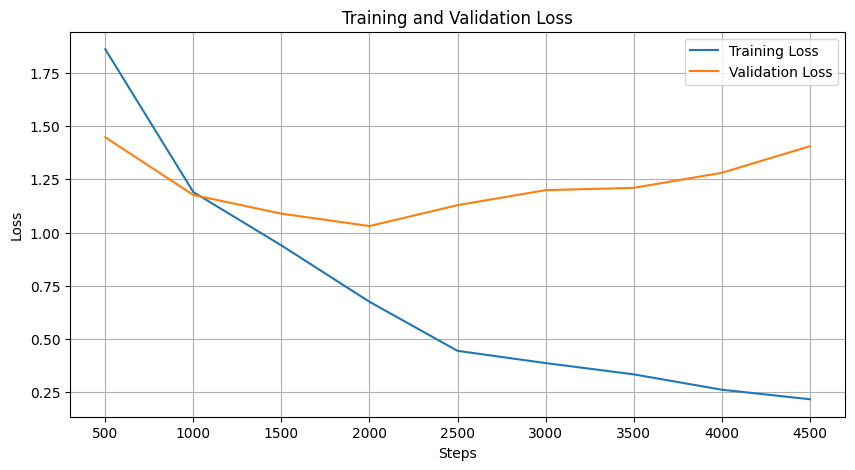

In [36]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [37]:
trainer.save_model('/content/drive/MyDrive/models/graphcodebert4')

In [ ]:
incorrect_samples

[{'labels': array([8, 0, 2, 2, 4, 2, 0, 7, 6, 4, 6, 9, 5, 2, 4, 2, 4, 0, 7, 1, 9, 9,
         1, 3, 7, 0, 8, 2, 4]),
  'input_ids': array([[    0, 47908, 26437, ...,     1,     1,     1],
         [    0, 47908, 26437, ...,     1,     1,     1],
         [    0, 47908, 26437, ...,     1,     1,     1],
         ...,
         [    0, 47908, 26437, ..., 10759, 12925,     2],
         [    0, 47908, 26437, ...,     1,     1,     1],
         [    0, 47908, 26437, ...,     1,     1,     1]]),
  'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])},
 {'labels': array([3, 7, 2, 3

In [ ]:
first_sample = incorrect_samples[0]
print(first_sample['labels'])
print(type(first_sample['labels']))
incorrect_samples[0]

[8 0 2 2 4 2 0 7 6 4 6 9 5 2 4 2 4 0 7 1 9 9 1 3 7 0 8 2 4]
<class 'numpy.ndarray'>


{'labels': array([8, 0, 2, 2, 4, 2, 0, 7, 6, 4, 6, 9, 5, 2, 4, 2, 4, 0, 7, 1, 9, 9,
        1, 3, 7, 0, 8, 2, 4]),
 'input_ids': array([[    0, 47908, 26437, ...,     1,     1,     1],
        [    0, 47908, 26437, ...,     1,     1,     1],
        [    0, 47908, 26437, ...,     1,     1,     1],
        ...,
        [    0, 47908, 26437, ..., 10759, 12925,     2],
        [    0, 47908, 26437, ...,     1,     1,     1],
        [    0, 47908, 26437, ...,     1,     1,     1]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])}

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import torch
from torch.utils.data import Dataset

class IncorrectSamplesDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples  # samples는 딕셔너리 형태입니다.

    def __len__(self):
        return len(self.samples)  # labels의 길이를 반환합니다.

    def __getitem__(self, idx):
        # 각 키에 대해 해당 인덱스의 데이터를 추출하고 텐서로 변환합니다.
        return {
            'input_ids': torch.tensor(self.samples['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.samples['attention_mask'][idx], dtype=torch.long),
            'token_type_ids': torch.tensor(self.samples['token_type_ids'][idx], dtype=torch.long),
            'labels': torch.tensor(self.samples['labels'][idx], dtype=torch.long)
        }




def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=0)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['labels'] for item in batch])

    # token_type_ids가 모든 데이터에 포함되어 있는 경우에만 처리
    token_type_ids = None
    if 'token_type_ids' in batch[0]:
        token_type_ids = pad_sequence([item['token_type_ids'] for item in batch], batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'labels': labels
    }



In [ ]:
# 데이터셋 인스턴스 생성
incorrect_dataset = IncorrectSamplesDataset(incorrect_samples)

# 데이터셋 정보 출력
print(incorrect_dataset)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

In [ ]:
from transformers import TrainingArguments, Trainer

# 데이터셋 인스턴스 생성
incorrect_dataset = IncorrectSamplesDataset(incorrect_samples)

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',     # 모델과 체크포인트 저장 경로
    evaluation_strategy="steps",
    eval_steps=50,              # 평가 주기 설정
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,         # 재학습할 에폭 수
    weight_decay=0.01
)

# Trainer 인스턴스 생성
trainer = Trainer(
    model=model,                # 재학습할 모델
    args=training_args,
    train_dataset=incorrect_dataset,  # 재학습을 위한 데이터셋
    eval_dataset=encoded_dataset['test'], # 평가를 위한 데이터셋
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)


In [ ]:
trainer.train()

TypeError: list indices must be integers or slices, not str

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

In [ ]:
import pandas as pd

df2 = pd.read_csv("/content/drive/MyDrive/Dataset/final/Last_test.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset/final/Last_test.csv'

In [ ]:
df2 = df2[['labels', 'code']]

NameError: name 'df2' is not defined

In [ ]:
df2

NameError: name 'df2' is not defined

In [ ]:
import re

def preprocess2(df2, file_name):
    # 멀티 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df2['code'] = df2['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df2['code'] = df2['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df2['code'] = df2['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df2['code'] = df2['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df2['code'] = df2['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df2['code'] = df2['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'\n'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df2['code'] = df2['code'].replace(re.compile(r'return;'), "", regex=True)
    # void func 로 변경
    df2['code'] = df2['code'].replace(re.compile(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{'), r"void func(\3){", regex=True)
    # 데이터프레임을 CSV 파일로 저장
    df2.to_csv(file_name, index=False)
    return df2  # 수정된 데이터프레임 반환


def tokenized(examples):
  return tokenizer(examples['code'], pad_to_max_length=True, max_length=MAX_LEN,truncation=True, return_token_type_ids=True)

In [ ]:
preprocess2(df2,"preprocess2.csv")
dataset = load_dataset("csv",data_files="preprocess2.csv")['train']
encoded_dataset2 = dataset.map(tokenized,remove_columns=['code'],batched=True)

NameError: name 'df2' is not defined

In [ ]:
df3 = pd.read_csv("/content/preprocess2.csv")

In [ ]:
encoded_dataset2

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 110
})

In [ ]:
trainer.predict(encoded_dataset['test'])

PredictionOutput(predictions=array([[ 0.02742812, -0.39351386,  0.0540446 , ..., -0.10310733,
         0.17207724,  0.03516811],
       [ 0.1255419 , -0.32383606,  0.14054807, ..., -0.015842  ,
         0.07655281, -0.02318546],
       [ 0.16482355, -0.26796117,  0.07672805, ..., -0.00980937,
         0.31677282,  0.00193137],
       ...,
       [ 0.15172961, -0.3624328 ,  0.0224196 , ..., -0.0870866 ,
         0.28315598,  0.01673019],
       [ 0.09528061, -0.35663185,  0.06933878, ..., -0.05413456,
         0.16247916,  0.05344477],
       [ 0.09994929, -0.32379842,  0.04181524, ..., -0.06413194,
         0.15221582, -0.02132664]], dtype=float32), label_ids=array([5, 1, 0, ..., 0, 2, 5]), metrics={'test_loss': 2.405827045440674, 'test_accuracy': 0.06340057636887608, 'test_recall_weighted': 0.06340057636887608, 'test_f1_weighted': 0.024242515105402596, 'test_f1_macro': 0.021271469488643415, 'test_f1_micro': 0.06340057636887608, 'test_f1_class_0': 0.09350237717908082, 'test_f1_class_1'